In [93]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import unidecode
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import xgboost
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from collections import Counter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


# Load Data

In [5]:
df = pd.read_csv("C:/Users/krist/Desktop/datasets/spamraw.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   sms_text  5000 non-null   object
 2   spam      5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


,id,sms_text,spam
0,1,Hope you are having a good week. Just checking in,0
1,2,K..give back my thanks.,0
2,3,Am also doing in cbe only. But have to pay.,0
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1
4,5,okmail: Dear Dave this is your final notice to...,1


In [6]:
np.bincount(df['spam'])

array([4327,  673], dtype=int64)

In [7]:
df.isna().sum()

id          0
sms_text    0
spam        0
dtype: int64

In [8]:
blanks=[]
for index,id,sms_text,spam in df.itertuples():
    if type(sms_text)==str:
        if sms_text.isspace():
            blanks.append(index)

In [13]:
blanks

[]

In [9]:
df['spam'].value_counts()/len(df) #highly imbalanced

0    0.8654
1    0.1346
Name: spam, dtype: float64

In [10]:
df["text_len"]=df["sms_text"].apply(lambda x:len(x)-x.count(" "))
df.head()

,id,sms_text,spam,text_len
0,1,Hope you are having a good week. Just checking in,0,40
1,2,K..give back my thanks.,0,20
2,3,Am also doing in cbe only. But have to pay.,0,34
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1,129
4,5,okmail: Dear Dave this is your final notice to...,1,135


<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

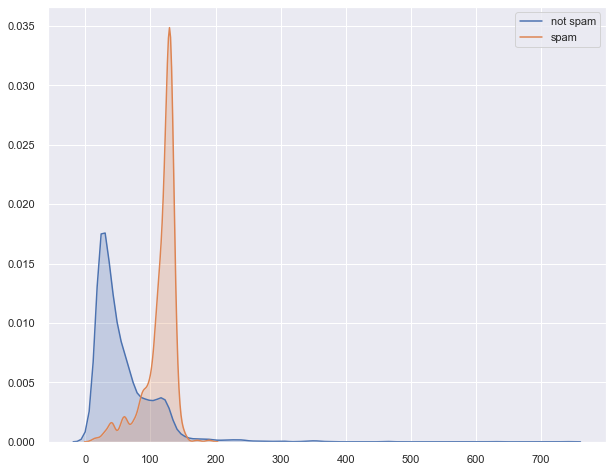

In [11]:
import seaborn as sns
plt.figure(figsize=(10,8))

sns.set(color_codes=True)
sns.kdeplot(df[df['spam']==0]['text_len'],shade=True,label='not spam') #this feature seems important
sns.kdeplot(df[df['spam']==1]['text_len'],shade=True,label='spam')

In [12]:
import textstat
#easy readability scores
df['flesch_reading_ease']=df['sms_text'].apply(textstat.flesch_reading_ease)
df['automated_readability']=df['sms_text'].apply(textstat.automated_readability_index)

<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

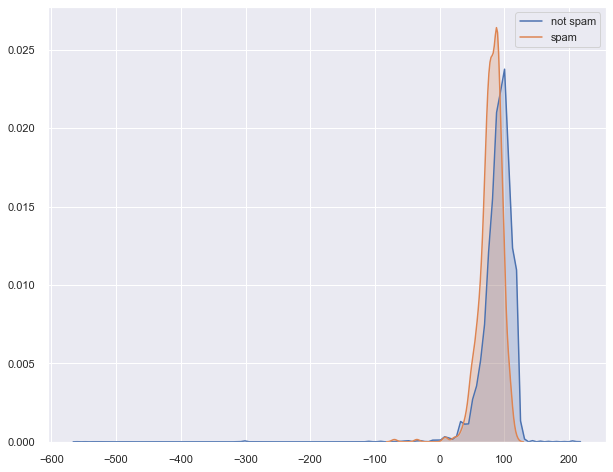

In [13]:
plt.figure(figsize=(10,8))

sns.set(color_codes=True)
sns.kdeplot(df[df['spam']==0]['flesch_reading_ease'],shade=True,label='not spam') #this feature seems important
sns.kdeplot(df[df['spam']==1]['flesch_reading_ease'],shade=True,label='spam')

In [14]:
def count_capitalized(text):
    count=sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_capitalized"]=df["sms_text"].apply(lambda x:count_capitalized(x))  
df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1,129,50.16,18.0,18.6
4,5,okmail: Dear Dave this is your final notice to...,1,135,87.72,6.6,14.1


<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

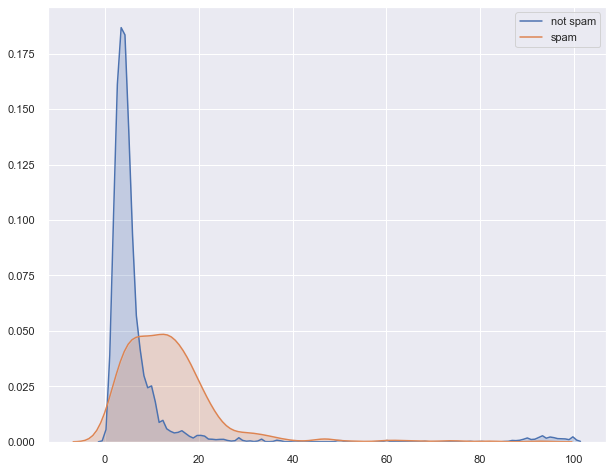

In [15]:
plt.figure(figsize=(10,8))

sns.set(color_codes=True)
sns.kdeplot(df[df['spam']==0]['text_capitalized'],shade=True,label='not spam') #this feature seems important
sns.kdeplot(df[df['spam']==1]['text_capitalized'],shade=True,label='spam')

In [16]:
#% of messages that contain digits
def count_digit(text):
    count=sum([1 for char in text if char.isdigit()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_digit"]=df["sms_text"].apply(lambda x:count_digit(x))  
df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized,text_digit
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0,0.0
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0,0.0
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9,0.0
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1,129,50.16,18.0,18.6,20.9
4,5,okmail: Dear Dave this is your final notice to...,1,135,87.72,6.6,14.1,17.8


<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

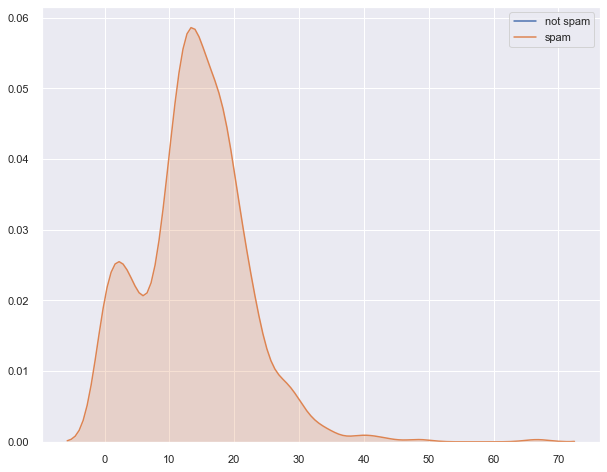

In [17]:
plt.figure(figsize=(10,8))

sns.set(color_codes=True)
sns.kdeplot(df[df['spam']==0]['text_digit'],shade=True,label='not spam')
sns.kdeplot(df[df['spam']==1]['text_digit'],shade=True,label='spam')

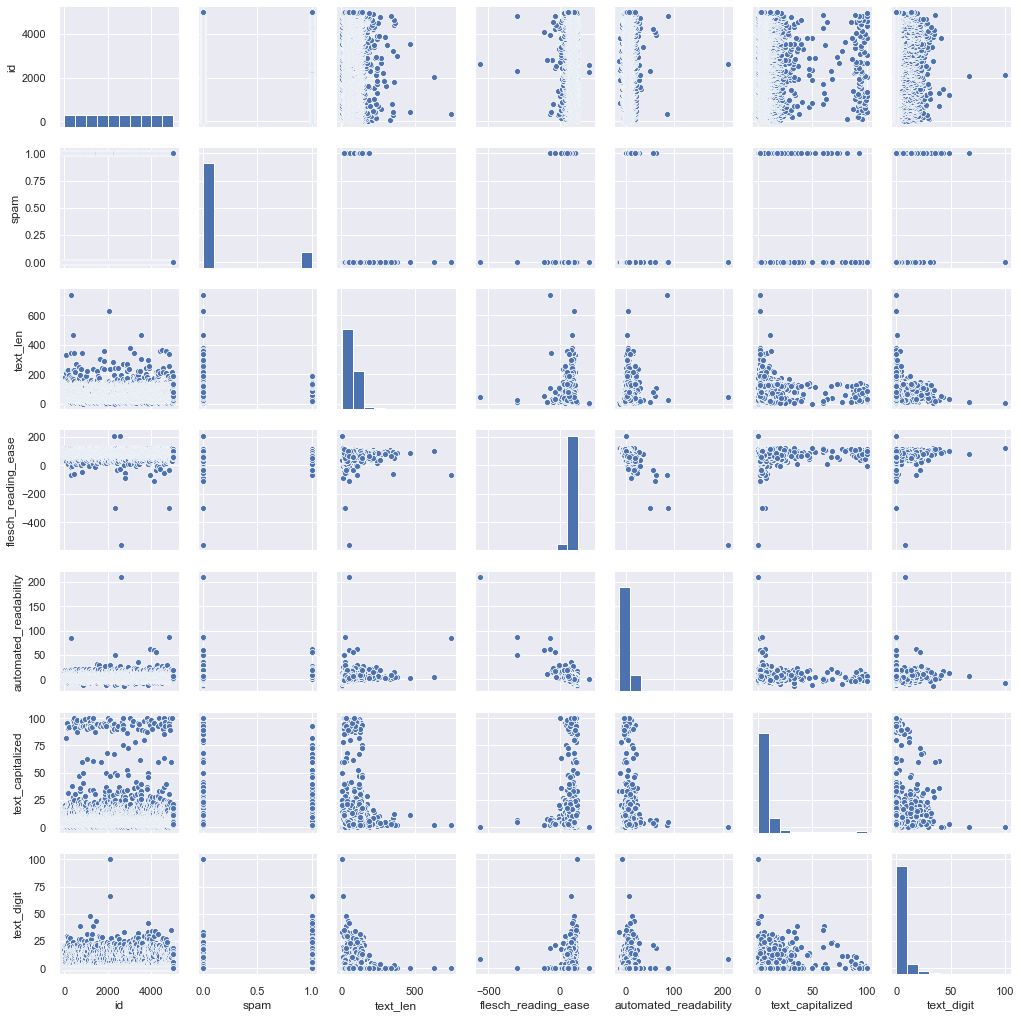

In [36]:
sns.pairplot(df,diag_kind='hist',height=2)

In [18]:
def count_punctuation(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_punctuation"]=df["sms_text"].apply(lambda x:count_punctuation(x))  
df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized,text_digit,text_punctuation
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0,0.0,2.5
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0,0.0,15.0
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9,0.0,5.9
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1,129,50.16,18.0,18.6,20.9,3.1
4,5,okmail: Dear Dave this is your final notice to...,1,135,87.72,6.6,14.1,17.8,3.7


<Figure size 720x576 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

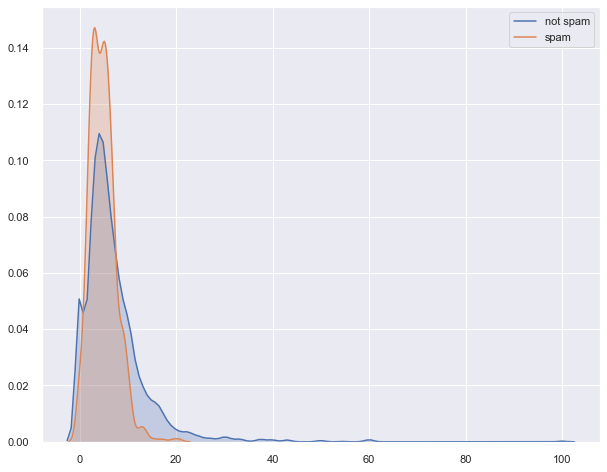

In [19]:
plt.figure(figsize=(10,8))

sns.kdeplot(df[df['spam']==0]['text_punctuation'],shade=True,label='not spam') #this feature seems important
sns.kdeplot(df[df['spam']==1]['text_punctuation'],shade=True,label='spam')

In [27]:
def extract_smile(row):
    pattern=r':\)|:\('
    if re.findall(pattern, row):
        return 1
    else:
        return 0

df["text_smile"]=df["sms_text"].apply(extract_smile)

In [33]:
df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized,text_digit,text_punctuation,text_smile
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0,0.0,2.5,0
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0,0.0,15.0,0
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9,0.0,5.9,0
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+",1,129,50.16,18.0,18.6,20.9,3.1,0
4,5,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm,1,135,87.72,6.6,14.1,17.8,3.7,0


In [34]:
#looking for presence of # or specific words, email address,money,phone number, http

def string_search(text):
    pattern=r'prize|URGENT|urgent|FREE|winner|WINNER|WIN|OFFER|offer|gift|Congratulations|Chance|chance|complimentary|@\S+|\b[\w\-.]+?@\w+?\b|£|\$|\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}|http\S+'
    if re.findall(pattern,text):
        return 1
    else:
        return 0
df["text_special_string"]=df["sms_text"].apply(lambda x:string_search(x))  
df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized,text_digit,text_punctuation,text_smile,text_special_string
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0,0.0,2.5,0,0
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0,0.0,15.0,0,0
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9,0.0,5.9,0,0
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+",1,129,50.16,18.0,18.6,20.9,3.1,0,1
4,5,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm,1,135,87.72,6.6,14.1,17.8,3.7,0,1


In [37]:
sid=SentimentIntensityAnalyzer()
#adding a column with compound scores produced by VADER
df['sentiment_compound']=df['sms_text'].apply(lambda r:sid.polarity_scores(r)["compound"])

In [38]:
def score_classifier(row):
    if row>0:
        return 'positive'
    elif row<0:
        return 'negative'
    else:
        return 'neutral'
df['sentiment']=df['sentiment_compound'].apply(score_classifier)

#mapping sentiment to 0 or 1 since 1 is >0 in this case
df['sentiment_mapped']=df['sentiment'].map({'positive': 1, 'negative': -1,'neutral':0})

df.drop(["sentiment_compound","sentiment"],axis=1,inplace=True)

df.head()

,id,sms_text,spam,text_len,flesch_reading_ease,automated_readability,text_capitalized,text_digit,text_punctuation,text_smile,text_special_string,sentiment_mapped
0,1,Hope you are having a good week. Just checking in,0,40,100.24,-0.2,5.0,0.0,2.5,0,0,1
1,2,K..give back my thanks.,0,20,118.18,4.1,5.0,0.0,15.0,0,0,1
2,3,Am also doing in cbe only. But have to pay.,0,34,91.78,-3.0,5.9,0.0,5.9,0,0,-1
3,4,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+",1,129,50.16,18.0,18.6,20.9,3.1,0,1,1
4,5,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm,1,135,87.72,6.6,14.1,17.8,3.7,0,1,1


In [42]:
#doing data preprocessing 
wn=nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

def clean_text(text):
        text = BeautifulSoup(text, ["lxml"]).get_text()        
        text="".join([char.lower() for char in text if char not in string.punctuation]) 
        text= re.sub(r'\d+', '', text)
        text=re.sub(r'http\S+|www\S+', '', text).strip() #removing http: links
        tokens=re.split('\W+', text.strip()) 
        text=[unidecode.unidecode(tokens) for tokens in tokens]
        text=[wn.lemmatize(word) for word in tokens if word not in stop_words]
        return text

In [49]:
#After cleaning the data, split into train/test
X = df.drop("spam",axis=1)
y = df[['spam']]

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [50]:
X_train.shape

(1629, 11)

In [51]:
X_test.shape

(1000, 11)

In [52]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text,max_df=0.8,min_df=0.02,ngram_range=[1,2]) 
df_tfidf = tfidf_vect.fit(X_train["sms_text"])

X_tfidf_train=df_tfidf.transform(X_train["sms_text"])
X_tfidf_test=df_tfidf.transform(X_test["sms_text"])

In [54]:
X_count_features_train=pd.concat([X_train[['text_len',"text_capitalized","text_digit","text_smile","text_punctuation","text_special_string",
                          "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                            pd.DataFrame(X_tfidf_train.toarray(),columns=tfidf_vect.get_feature_names())], axis=1)

X_count_features_test=pd.concat([X_test[['text_len',"text_capitalized","text_digit","text_smile","text_punctuation","text_special_string",
                                   "sentiment_mapped","flesch_reading_ease","automated_readability"]].reset_index(drop=True),
                            pd.DataFrame(X_tfidf_test.toarray(),columns=tfidf_vect.get_feature_names())], axis=1)

In [57]:
import time
from sklearn.metrics import f1_score

lr = LogisticRegression(random_state=42) 
gb=xgboost.XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=200)
ada = AdaBoostClassifier(random_state=42, n_estimators=200)

classifiers = {
    "LR": lr, 
    "RF": rf,
    "Adaboost": ada,
    "GBC": gb
}

model_results = list()
    
for model_name,model in classifiers.items():
    start = time.time()
    fitting=model.fit(X_count_features_train,y_train)
    end = time.time()
    total = end - start
    y_pred=fitting.predict(X_count_features_test)
    f1=f1_score(y_test, y_pred, average='macro')
     
    df_results = pd.DataFrame({"Method": [model_name],
                               "Time" : [total],
                               "F1" : [f1]
                             })
    model_results.append(df_results)
    
    dataset_results = pd.concat([m for m in model_results], axis = 0).reset_index() 
    dataset_results = dataset_results.drop(columns = "index",axis =1)
    dataset_results = dataset_results.sort_values(by=['F1'], ascending=False)
    dataset_results['Rank'] = range(1, len(dataset_results)+1)
print(dataset_results)

     Method      Time        F1  Rank
1        RF  1.392105  0.969054     1
3       GBC  3.995300  0.964863     2
2  Adaboost  1.882653  0.957448     3
0        LR  0.143011  0.947967     4


<AxesSubplot:>

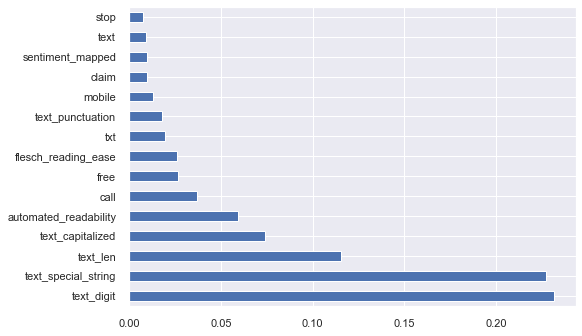

In [58]:
#Feature importance plot
feat_importances = pd.Series(rf.feature_importances_,
index=X_count_features_train.columns).sort_values(ascending=False)
feat_importances.nlargest(15).plot(kind='barh')

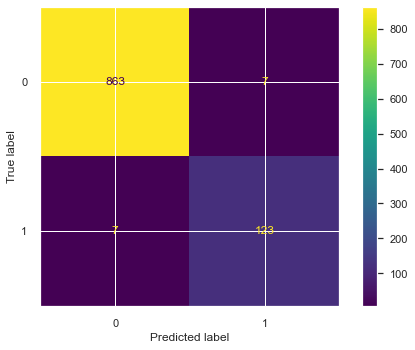

In [89]:
rf_model=rf.fit(X_count_features_train,y_train)
y_pred=rf_model.predict(X_count_features_test)

plot_confusion_matrix(rf_model,X_count_features_test,y_test)

In [94]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       870
           1       0.95      0.95      0.95       130

    accuracy                           0.99      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.99      0.99      0.99      1000



In [59]:
rf=RandomForestClassifier(random_state=42)

parameters={"min_samples_leaf":[1,3,5,10],
            "max_depth":[10,15,20,25],
             "max_features":[1,5,15,17],
            "n_estimators":[100,200,300],
             "criterion":["gini","entropy"]}

rf_cv=GridSearchCV(rf,param_grid=parameters,cv=10)
rf_cv=rf_cv.fit(X_count_features_train,y_train)
rf_y_pred=rf_cv.predict(X_count_features_test)
f1=f1_score(y_test, y_pred, average='macro')

In [60]:
f1

0.9648626569101977